<a href="https://colab.research.google.com/github/abhinav-exp/Forecasting-CryptoCurrency-Prices/blob/master/TFLANN_with_JAYA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
GitHubDataLink = 'https://raw.githubusercontent.com/abhinav-exp/Forecasting-CryptoCurrency-Prices/master/Datasets/'
InputFileLink = GitHubDataLink + 'DataBTC2017.csv'
data1 = pd.read_csv(InputFileLink, header=0, index_col=0)
print(data1)

            CBBTCUSD
DATE                
2017-06-18   2515.25
2017-06-19   2596.98
2017-06-20   2725.08
2017-06-21   2643.35
2017-06-22   2679.99
...              ...
2019-08-03  10820.75
2019-08-04  10997.82
2019-08-05  11775.14
2019-08-06  11440.08
2019-08-07  12014.41

[781 rows x 1 columns]


In [4]:
data1min = data1.min()
data1max = data1.max()

normalize = lambda x: (x - data1min + 1)/(data1max - data1min + 2)
data2 = normalize(data1)
print(data2)

            CBBTCUSD
DATE                
2017-06-18  0.034073
2017-06-19  0.038680
2017-06-20  0.045901
2017-06-21  0.041294
2017-06-22  0.043360
...              ...
2019-08-03  0.502247
2019-08-04  0.512228
2019-08-05  0.556045
2019-08-06  0.537158
2019-08-07  0.569532

[781 rows x 1 columns]


In [5]:
def split_sequence(sequence, n_steps):
  X= list()
  for i in range(len(sequence) - n_steps):
    end_ix = i + n_steps
    seq_x= sequence.values[i:end_ix, 0]
    X.append(seq_x) 
  return pd.DataFrame(X)

data3 = split_sequence(data2, 10)
print(data3.shape)
print(data3)

(771, 10)
            0         1         2         3         4         5         6  \
0    0.034073  0.038680  0.045901  0.041294  0.043360  0.043967  0.037432   
1    0.038680  0.045901  0.041294  0.043360  0.043967  0.037432  0.033530   
2    0.045901  0.041294  0.043360  0.043967  0.037432  0.033530  0.028023   
3    0.041294  0.043360  0.043967  0.037432  0.033530  0.028023  0.037484   
4    0.043360  0.043967  0.037432  0.033530  0.028023  0.037484  0.036208   
..        ...       ...       ...       ...       ...       ...       ...   
766  0.441959  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307   
767  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562   
768  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501   
769  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030   
770  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030  0.502247   

            7         8         9  
0    0.033530  0.028023  0.03

In [6]:
train_x = data3.iloc[:int(0.85*len(data2)), :9]
train_y = data3.iloc[:int(0.85*len(data2)), 9:10]
test_x = data3.iloc[int(0.85*len(data2)):, :9]
test_y = data3.iloc[int(0.85*len(data2)):, 9:10]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(663, 9)
(663, 1)
(108, 9)
(108, 1)


In [70]:
class TFLANN():
  def __init__(self, W):
    self.weight_matrix = W
  
  def func_x(self, x):
    const_x = np.ones((len(x), 1))
    orginal_x = x
    sinned_x = np.sin(np.pi*x)
    cossed_x = np.cos(np.pi*x)
    # print(const_x)
    # print(x.shape)
    # print(const_x.shape)
    functioned_x = np.hstack((x, sinned_x, cossed_x, const_x))
    return functioned_x

  def forward_propagation(self, x):
    funced_x = self.func_x(x)
    return (np.tanh(np.dot(funced_x, self.weight_matrix)) + 1)/2

In [188]:
find_mse = lambda x , y: np.mean((x - y) ** 2)

class JAYATFLANN():
  def __init__(self, p_size):
    self.p_size = p_size
    self.data = []

    for i in range(p_size):
      d = {}
      d['W'] = np.random.random((9*3 + 1, 1))
      model = TFLANN(d['W'])
      d['mse'] = find_mse(model.forward_propagation(train_x), train_y)
      self.data.append(d)

    print(sum([v['mse'][9] for v in self.data]))
    print([v['mse'][9] for v in self.data])

    self.update_best_and_worst()

  def update_best_and_worst(self):
    self.best = 0
    self.worst = 0
    for i in range(self.p_size):
      if self.data[self.best]['mse'][9] > self.data[i]['mse'][9]:
        self.best = i
      if self.data[self.worst]['mse'][9] < self.data[i]['mse'][9]:
        self.worst = i

  def next_gen(self):
    for i in range(self.p_size):
      t =  self.data[i]['W']
      t += np.random.normal(loc = 0.75, scale = 0.15, size = (9*3 + 1, 1))* (self.data[self.best]['W'] - self.data[i]['W'])
      t -= np.random.normal(loc = 0.75, scale = 0.15, size = (9*3 + 1, 1)) * (self.data[self.worst]['W'] - self.data[i]['W'])
      model = TFLANN(t)
      mse = find_mse(model.forward_propagation(train_x), train_y)
      if mse[9] < self.data[i]['mse'][9]:
        self.data[i] = {'W': t, 'mse':mse}

    self.update_best_and_worst()

  def optimise(self, gen):
    for i in range(gen):
      self.next_gen()
      print(str(self.data[self.best]['mse'][9]) + "\t" + str(self.data[self.worst]['mse'][9]))

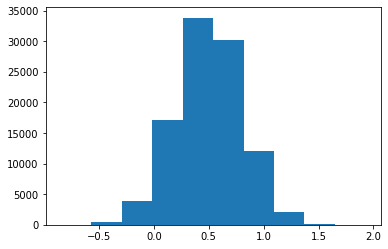

In [116]:
plt.hist(np.random.normal(loc = 0.5, scale = 0.3, size = (100000)))
plt.show()

In [189]:
optimiser = JAYATFLANN(50)
optimiser.optimise(100)
model = TFLANN(optimiser.data[optimiser.best]['W'])
preds = model.forward_propagation(test_x)
print(preds.shape)

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


28.634701759657457
[0.5717243047074312, 0.5726780815903261, 0.5723921478054614, 0.5726872562238462, 0.5726847495280125, 0.5726486437169208, 0.5726397244286159, 0.5723310941893868, 0.5721557055393293, 0.5726259983241521, 0.5723704993098413, 0.572654428004166, 0.5726332560037568, 0.572449241176663, 0.5726782600104836, 0.5726637715482437, 0.5724693859187006, 0.5725522426460824, 0.572654183360344, 0.5726330226308051, 0.5726653797818327, 0.5726478130513494, 0.5723888346625352, 0.5726729619997434, 0.5722177036720711, 0.5780093554992336, 0.5725817794914053, 0.5726563974339209, 0.5722645136059974, 0.5726533726767763, 0.572356065038195, 0.5725443107234401, 0.5725365605115083, 0.5733430024339895, 0.572584200175666, 0.5726875738702747, 0.5726597791801115, 0.5725328867491131, 0.5725021928449845, 0.5724020121954068, 0.5726813284654922, 0.5726878733846686, 0.5724919809278887, 0.5726837062102558, 0.572464451812021, 0.5725650848837373, 0.5738868259695341, 0.572664064736252, 0.5724184680386099, 0.57292

In [190]:
preds[:, 0]

array([0.10640565, 0.11772308, 0.10875565, 0.11300682, 0.11570855,
       0.10770258, 0.10024788, 0.10920195, 0.11829756, 0.12373813,
       0.12534169, 0.14606837, 0.13088761, 0.12171954, 0.12259236,
       0.11722143, 0.10184383, 0.09495334, 0.10602954, 0.11211881,
       0.11894316, 0.14102101, 0.15677596, 0.12130109, 0.14353333,
       0.10184006, 0.13070733, 0.06584692, 0.08369312, 0.11972402,
       0.23545172, 0.25489196, 0.21736529, 0.14024992, 0.18824715,
       0.17376671, 0.23504041, 0.2873126 , 0.24271163, 0.19887259,
       0.14748332, 0.16262803, 0.22704143, 0.26228483, 0.30721626,
       0.18519872, 0.1836524 , 0.20136745, 0.2802038 , 0.30452388,
       0.2448528 , 0.20653426, 0.19984832, 0.1911595 , 0.23338373,
       0.20734773, 0.27140803, 0.23036126, 0.23982215, 0.24017442,
       0.21557628, 0.26236845, 0.31618797, 0.48246433, 0.5304486 ,
       0.51039846, 0.51491878, 0.65596368, 0.80886058, 0.64244896,
       0.79315494, 0.69231143, 0.74411595, 0.80753235, 0.74874

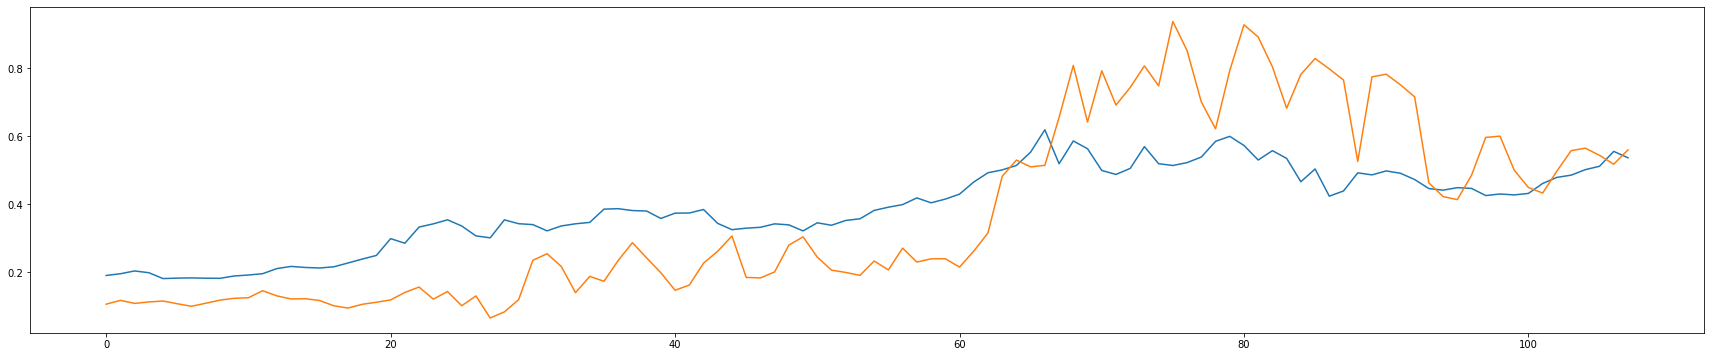

In [191]:
plt.figure(figsize=(30, 6))
plt.plot(test_y.reset_index()[9])
plt.plot(preds)
plt.show()